# Options IV Calculation Test

This notebook tests the options data fetching and implied volatility (IV) calculation pipeline.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from adapters.options_adapter import OptionsAdapter
from adapters.rates_adapter import RatesAdapter
from adapters.ticker_adapter import TickerAdapter
from models.options_data import OptionsRequest, OptionType
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
from engines.IV_smile import IVEngine


In [4]:
from update_rates import updateRates
updateRates()

FRED_API_KEY present: yes
Starting updateRates...
Starting rate updates...
No new discount factor data available from 2025-12-19
No new SOFR data available from 2025-12-19
Rate updates completed.
updateRates completed.
Last discount_factors date: 2025-12-18
SOFR update was included.


## Setup

Initialize the adapter and create the options request.


In [68]:
adapter = OptionsAdapter()

# Simulate duration selection (e.g. '1y' from frontend)
today = date.today()
expiry_start = today + relativedelta(weeks=4)
expiry_end = today + relativedelta(weeks=56)

req = OptionsRequest(
    ticker="AAPL",
    optionType=OptionType.CALL,
    expiryStart=expiry_start,
    expiryEnd=expiry_end,
    moneynessMin=0.8,
    moneynessMax=1.2,
)


## Fetch Options Data


In [ ]:
print(f"Requesting options for {req.ticker} until {expiry_end}...")
df = adapter.fetch_option_chain(req)
print(f"Fetched {len(df)} contracts.")


Requesting options for AAPL until 2027-01-18...
Fetched 255 contracts.


## Display Options Data


In [70]:
df[["optionType", "strike", "timeToExpiry", "midPrice", "expiry"]]

,optionType,strike,timeToExpiry,midPrice,expiry
0,call,220.0,0.088575,54.410,2026-01-23
1,call,225.0,0.088575,50.020,2026-01-23
2,call,230.0,0.088575,44.765,2026-01-23
3,call,235.0,0.088575,39.665,2026-01-23
4,call,240.0,0.088575,34.605,2026-01-23
...,...,...,...,...,...
250,call,290.0,1.066657,26.370,2027-01-15
251,call,300.0,1.066657,22.335,2027-01-15
252,call,310.0,1.066657,18.250,2027-01-15
253,call,320.0,1.066657,15.115,2027-01-15


## Calculate Implied Volatility


In [71]:
from engines.zero_rates import ZeroRatesEngine

df["rate"] = ZeroRatesEngine.interpolate_zero_rate(df, tte_col="timeToExpiry")

base_info = TickerAdapter.fetchBasic(req.ticker)
div = base_info.dividendYield
spot = base_info.spot
#
#print(f"Spot price: ${spot:.2f}")
#print(f"Risk-free rate: {rate:.4f}")
#print(f"Dividend yield: {div:.4f}%")
#print("\nCalculating IVs...")
#
surface_data = IVEngine.generateIVSmile(df, df["rate"], div/100, spot, OptionType.CALL) #type: ignore
surface_data.dropna(inplace=True)




In [72]:
print("\nIV Calculation Results:")
surface_data[["expiry", "iv"]]



IV Calculation Results:


,expiry,iv
0,2026-01-23,0.335088
1,2026-01-23,0.416500
2,2026-01-23,0.343506
3,2026-01-23,0.291124
4,2026-01-23,0.245495
...,...,...
250,2027-01-15,0.262059
251,2027-01-15,0.259204
252,2027-01-15,0.251733
253,2027-01-15,0.248800


In [73]:
import numpy as np
surface_data["F"] = spot * np.exp((surface_data["rate"] - div/100) * surface_data["T"])
surface_data["k"] = np.log(surface_data["K"] / surface_data["F"])
surface_data["w"] = surface_data["iv"] ** 2 * surface_data["T"]
surface_data[["K", "w", "k", "expiry" ,"F"]]
#print(f"Spot: {spot}")

,K,w,k,expiry,F
0,220.0,0.009946,-0.221232,2026-01-23,274.474848
1,225.0,0.015365,-0.198759,2026-01-23,274.474848
2,230.0,0.010452,-0.176780,2026-01-23,274.474848
3,235.0,0.007507,-0.155274,2026-01-23,274.474848
4,240.0,0.005338,-0.134221,2026-01-23,274.474848
...,...,...,...,...,...
250,290.0,0.073253,0.025154,2027-01-15,282.796432
251,300.0,0.071665,0.059055,2027-01-15,282.796432
252,310.0,0.067593,0.091845,2027-01-15,282.796432
253,320.0,0.066028,0.123594,2027-01-15,282.796432


In [74]:
thetas = surface_data.loc[surface_data["k"].abs().groupby(surface_data["T"]).idxmin()][["T", "k", "w"]].reset_index(drop=True)
thetas

,T,k,w
0,0.088575,0.001911,0.003744
1,0.107753,0.001303,0.006015
2,0.165288,-0.000523,0.008842
3,0.241886,-0.002954,0.013941
4,0.318598,-0.005347,0.018172
5,0.395310,-0.007735,0.025764
6,0.488461,0.007384,0.030283
7,0.567913,0.004994,0.034996
8,0.663804,0.002127,0.044032
9,0.740516,-0.000166,0.050395


In [75]:
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import PchipInterpolator

In [76]:
iso = IsotonicRegression(increasing=True, out_of_bounds='clip')
theta_iso = iso.fit_transform(thetas["T"], thetas["w"])

theta_spline = PchipInterpolator(thetas["T"], theta_iso, extrapolate=True)
surface_data["theta"] = theta_spline(surface_data["T"])
surface_data[["expiry", "k", "w", "theta"]]

,expiry,k,w,theta
0,2026-01-23,-0.221232,0.009946,0.003744
1,2026-01-23,-0.198759,0.015365,0.003744
2,2026-01-23,-0.176780,0.010452,0.003744
3,2026-01-23,-0.155274,0.007507,0.003744
4,2026-01-23,-0.134221,0.005338,0.003744
...,...,...,...,...
250,2027-01-15,0.025154,0.073253,0.076794
251,2027-01-15,0.059055,0.071665,0.076794
252,2027-01-15,0.091845,0.067593,0.076794
253,2027-01-15,0.123594,0.066028,0.076794


In [77]:
#theta_low = surface_data[surface_data["k"] <0].groupby("T")[["expiry","k","w","K","F","iv"]].max()
#theta_high = surface_data[surface_data["k"] >0].groupby("T")[["expiry","k","w","K","F","iv"]].min()
#interpolated_values = theta_high["w"] - (theta_high["w"] - theta_low["w"]) * (theta_high["k"] / (theta_high["k"] - theta_low["k"]))
#print(theta_high.iloc[-1])
#print(theta_low.iloc[-5:])
#surface_data["theta"] = surface_data["T"].map(interpolated_values)
surface_data[["expiry", "k", "w", "theta"]]




,expiry,k,w,theta
0,2026-01-23,-0.221232,0.009946,0.003744
1,2026-01-23,-0.198759,0.015365,0.003744
2,2026-01-23,-0.176780,0.010452,0.003744
3,2026-01-23,-0.155274,0.007507,0.003744
4,2026-01-23,-0.134221,0.005338,0.003744
...,...,...,...,...
250,2027-01-15,0.025154,0.073253,0.076794
251,2027-01-15,0.059055,0.071665,0.076794
252,2027-01-15,0.091845,0.067593,0.076794
253,2027-01-15,0.123594,0.066028,0.076794


In [78]:
vega = IVEngine._vega(surface_data["iv"], surface_data["K"], surface_data["T"], surface_data["rate"], div, surface_data["F"])
surface_data["vega"] = np.clip(vega, 1e-6, None)
print(f"Spot price: ${spot:.2f}")
surface_data[["expiry", "K", "k", "vega"]]

Spot price: $273.67


,expiry,K,k,vega
0,2026-01-23,220.0,-0.221232,4.583952
1,2026-01-23,225.0,-0.198759,11.492354
2,2026-01-23,230.0,-0.176780,10.491150
3,2026-01-23,235.0,-0.155274,10.465553
4,2026-01-23,240.0,-0.134221,10.890175
...,...,...,...,...
250,2027-01-15,290.0,0.025154,32.550710
251,2027-01-15,300.0,0.059055,26.636939
252,2027-01-15,310.0,0.091845,20.227243
253,2027-01-15,320.0,0.123594,15.751853


In [79]:
T_vals = surface_data["T"].values
T_unique = np.sort(surface_data["T"].unique())
T_to_index = {t: i for i, t in enumerate(T_unique)}
idx = np.array([T_to_index[t] for t in T_vals]) # index for each row to use on T_unique to find eta
x0 = np.r_[ -0.3, np.full(len(T_unique), 0.5) ]    # rho, eta_i-1



In [80]:
def ssvi_w(k, theta, phi, rho):
    w_ssvi = (
        1
        / 2
        * theta
        * (1 + rho * phi * k + np.sqrt((phi * k + rho) ** 2 + 1 - rho**2))
    )
    return w_ssvi


In [81]:
vegas = surface_data["vega"].values
weights = vegas / np.sum(vegas)

In [82]:
def objective(x, theta, k, w_mkt, idx):
    rho_raw = x[0]
    rho = np.tanh(rho_raw) 
    eta = x[1:]
    phi = eta[idx] / np.sqrt(np.maximum(theta, 1e-12))
    w_model = ssvi_w(k, theta, phi, rho)
    error = (w_model - w_mkt)
    loss = np.dot(error, error) 
    return loss

In [83]:
#def butterfly_constraint(x):
#    eta, rho = x
#    return 2 - eta * (1 + abs(rho))

def make_constraints(n_expiries):
    cons = []
    for i in range(n_expiries):
        cons.append({
            "type": "ineq",
            "fun": lambda x, i=i: 2 - x[1+i] * (1 + abs(x[0]))
        })
    return cons


In [84]:
from scipy.optimize import minimize

bounds = [(-99.0, 99.0)] + [(1e-5, 2)] * len(T_unique)
w_mkt = surface_data["w"].values
k = surface_data["k"].values
theta = surface_data["theta"].values


res = minimize(
    objective,
    x0=x0,
    args=(theta, k, w_mkt, idx),
    method="SLSQP",
    bounds=bounds,
    constraints=make_constraints(len(T_unique))
)

#print(res.x)
print(f"Optimised Rho: {np.tanh(res.x[0]):.6f}")
print(f"Optimised Eta: {res.x[1:]}")

surface_data["w_ssvi"] = ssvi_w(k, theta, phi= res.x[1:][idx] / np.sqrt(np.maximum(theta, 1e-12)), rho=np.tanh(res.x[0])) #type: ignore
error = objective(res.x, theta, k, w_mkt, idx)
print(f"SSVI Loss: {error:.6f}")


err = np.abs(surface_data["w_ssvi"].values) - np.abs(surface_data["w"].values) # type: ignore
relative = err / np.maximum(np.abs(surface_data["w"].values), 1e-6) # type: ignore
print(f"Mean Relative Error: {np.mean(relative)*100:.4f}%")


Optimised Rho: -0.429138
Optimised Eta: [0.70722726 0.4903923  1.08301468 1.01100517 0.80776995 0.57077144
 0.85823768 1.06071059 0.77137389 0.84776671 0.90028337 0.9232345 ]
SSVI Loss: 0.000781
Mean Relative Error: -0.9453%


In [85]:
surface_data["residuals"] = surface_data["w_ssvi"] - surface_data["w"]
surface_data["relative_residuals"] = (surface_data["residuals"] / surface_data["w"])*100
surface_data[["expiry", "K", "iv", "w", "w_ssvi", "relative_residuals"]]

,expiry,K,iv,w,w_ssvi,relative_residuals
0,2026-01-23,220.0,0.335088,0.009946,0.009766,-1.802796
1,2026-01-23,225.0,0.416500,0.015365,0.009094,-40.814455
2,2026-01-23,230.0,0.343506,0.010452,0.008441,-19.238568
3,2026-01-23,235.0,0.291124,0.007507,0.007807,3.994776
4,2026-01-23,240.0,0.245495,0.005338,0.007193,34.745173
...,...,...,...,...,...,...
250,2027-01-15,290.0,0.262059,0.073253,0.074147,1.220241
251,2027-01-15,300.0,0.259204,0.071665,0.070967,-0.975060
252,2027-01-15,310.0,0.251733,0.067593,0.068358,1.131120
253,2027-01-15,320.0,0.248800,0.066028,0.066301,0.413511


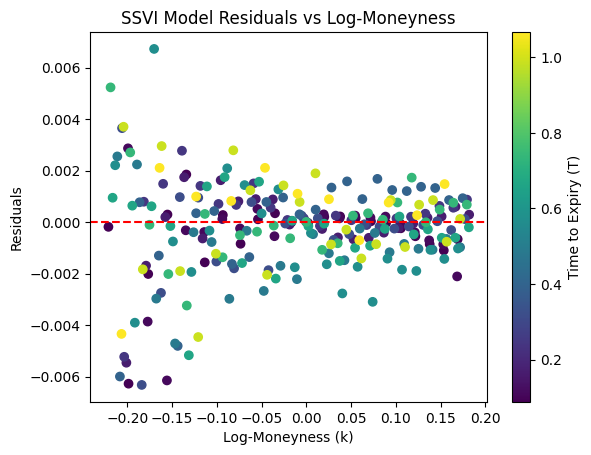

In [86]:
import matplotlib.pyplot as plt
plt.scatter(surface_data["k"], surface_data["residuals"], c=surface_data["T"], cmap="viridis")
plt.colorbar(label="Time to Expiry (T)")
plt.xlabel("Log-Moneyness (k)")
plt.ylabel("Residuals")
plt.title("SSVI Model Residuals vs Log-Moneyness")
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [87]:
mean_residuals = surface_data.groupby("expiry")["residuals"].mean()
mean_residuals = mean_residuals.rename("mean_residuals") 
#print(mean_residuals)
mean_relative_residuals = surface_data.groupby("expiry")["relative_residuals"].mean()
mean_relative_residuals = mean_relative_residuals.rename("mean_relative_residuals")
#print(mean_relative_residuals)

In [88]:
surface_data["iv_ssvi"] = np.sqrt(surface_data["w_ssvi"] / surface_data["T"])
surface_data["iv_error"] = (surface_data["iv_ssvi"] / surface_data["iv"] - 1)*100
surface_data[["expiry", "K", "iv", "iv_ssvi", "iv_error"]]

,expiry,K,iv,iv_ssvi,iv_error
0,2026-01-23,220.0,0.335088,0.332054,-0.905497
1,2026-01-23,225.0,0.416500,0.320423,-23.067858
2,2026-01-23,230.0,0.343506,0.308700,-10.132635
3,2026-01-23,235.0,0.291124,0.296882,1.977829
4,2026-01-23,240.0,0.245495,0.284970,16.079789
...,...,...,...,...,...
250,2027-01-15,290.0,0.262059,0.263653,0.608271
251,2027-01-15,300.0,0.259204,0.257937,-0.488724
252,2027-01-15,310.0,0.251733,0.253152,0.563970
253,2027-01-15,320.0,0.248800,0.249314,0.206542


C:\Users\gryph\AppData\Local\Temp\ipykernel_38516\4148399127.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


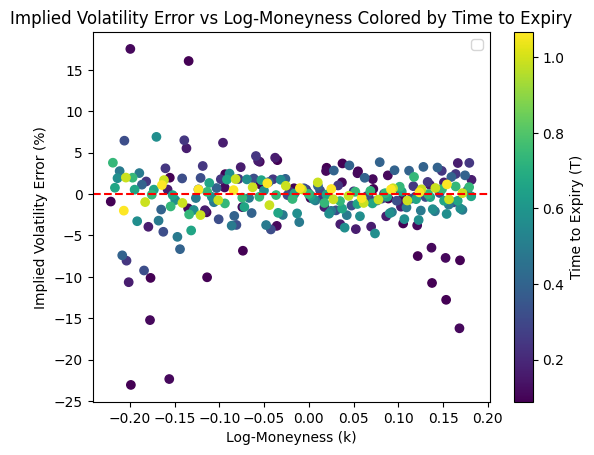

In [89]:
plt.scatter(surface_data["k"], surface_data["iv_error"], c=surface_data["T"], cmap="viridis")
plt.colorbar(label="Time to Expiry (T)")
plt.xlabel("Log-Moneyness (k)")
plt.ylabel("Implied Volatility Error (%)")
plt.title("Implied Volatility Error vs Log-Moneyness Colored by Time to Expiry")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()